# Import packages

In [2]:
import cdsapi
import os
import zipfile
import xarray as xr
import glob
import contextily as cx
import matplotlib.pyplot as plt
import pandas as pd
from bs4 import BeautifulSoup
from shapely.geometry import Polygon, Point
import geopandas as gpd
import requests
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

# Functions

In [3]:
def open_and_append_netcdf(zip_file_path, concatenated_data=None):
    # Extract the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('temp_folder')

    # List all files in the extracted folder
    extracted_files = os.listdir('temp_folder')

    # Filter out NetCDF files
    nc_files = [f for f in extracted_files if f.endswith('.nc')]

    # Sort NetCDF files alphabetically (optional)
    nc_files.sort()

    # Read NetCDF files using xarray and append to existing data (if any)
    for nc_file in nc_files:
        ds = xr.open_dataset(os.path.join('temp_folder', nc_file))
        if concatenated_data is None:
            concatenated_data = ds
        else:
            concatenated_data = xr.concat([concatenated_data, ds], dim='time')

    # Remove temporary extracted files
    for file in extracted_files:
        os.remove(os.path.join('temp_folder', file))
    os.rmdir('temp_folder')

    return concatenated_data

# Define AOI

Text(104.84722222222221, 0.5, 'Latitude (degrees)')

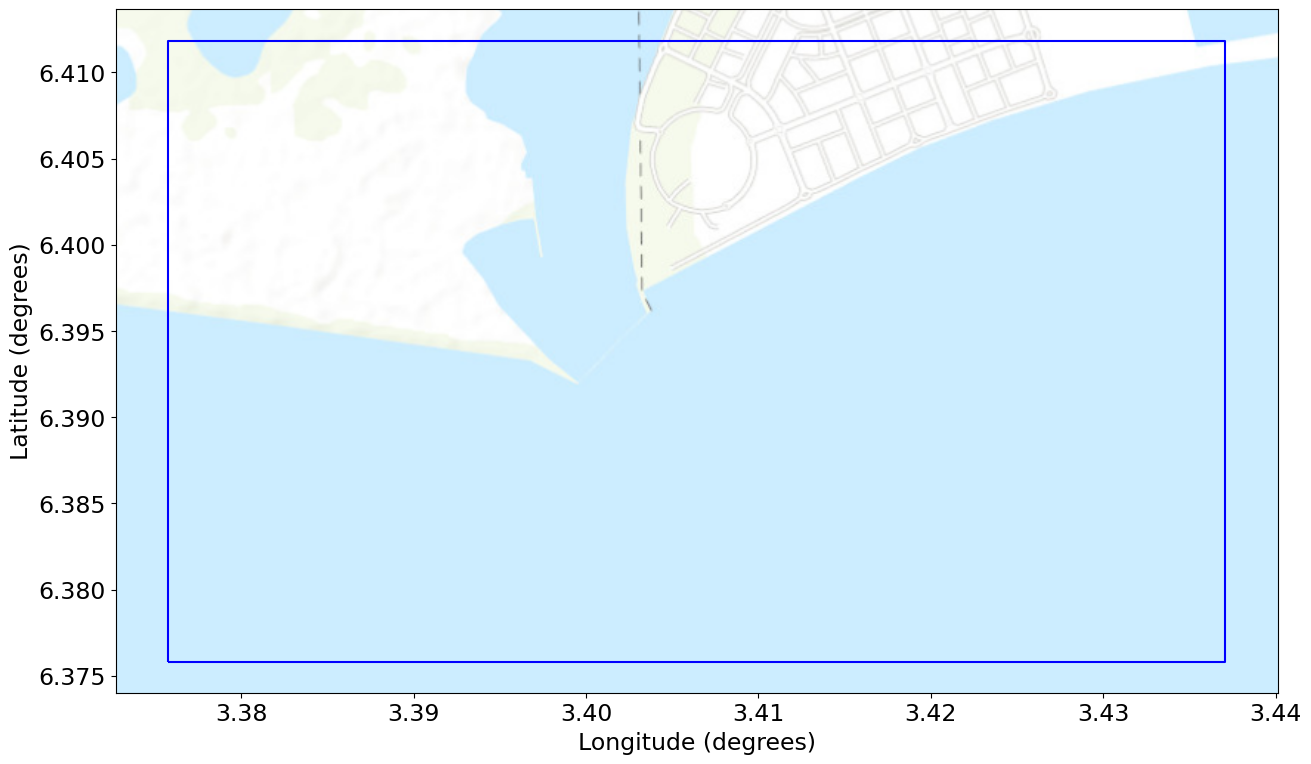

In [4]:
# Define the polygon coordinates (https://boundingbox.klokantech.com/)
polygon_coords = [[[3.3757754969,6.3758235962],[3.4370794029,6.3758235962],[3.4370794029,6.4118534479],[3.3757754969,6.4118534479],[3.3757754969,6.3758235962]]]

# Create a shapely Polygon object
polygon = Polygon(polygon_coords[0])

# Create a GeoDataFrame with a single row containing the polygon
geometry = [polygon]
gdf_aoi = gpd.GeoDataFrame(geometry, columns=['geometry'])
bb_aoi_bounds = gdf_aoi.bounds

# Plot the AOI
plt.rcParams['font.size'] = 17
fig, ax = plt.subplots(figsize=(15,9))
gdf_aoi.boundary.plot(ax=ax, color='blue')
cx.add_basemap(ax=ax, crs=4326, source=cx.providers.Esri.WorldTopoMap, attribution=False)
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')

# Define period to download

In [6]:
# Create GLOFAS directory to store downloaded files

gtsm_dir = '/Users/aprida/Desktop/gtsm' # Subfolder to store files per year
os.makedirs(gtsm_dir, exist_ok=True)

In [8]:
# Define years, months and days to download GLOFAS discharge

year_start = 2012
year_end = 2012
month_start = 1
month_end = 12
day_start = 1
day_end = 31

years = [str(element) for element in list(range(year_start, year_end+1))]
months = [f'{element:02}' for element in range(month_start, month_end + 1)]
days = [str(element) for element in list(range(day_start, day_end+1))]

# Download data via CDS API

In [45]:
dataset = "sis-water-level-change-timeseries-cmip6"

for year in years:

    request = {
        "variable": [
            "storm_surge_residual",
            "total_water_level"
        ],
        "experiment": "reanalysis",
        "temporal_aggregation": ["daily_maximum"],
        "year": year,
        "month": months
    }

client = cdsapi.Client()
fn = f'{gtsm_dir}/gtsm_{year}.zip'
client.retrieve(dataset, request, target=fn)

2024-12-13 23:06:27,182 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-12-13 23:06:27,193 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-12-13 23:06:27,197 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-12-13 23:06:27,199 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using t

ff158d283118809b575e7479e71069d7.zip:   0%|          | 0.00/37.7M [00:00<?, ?B/s]

'/Users/aprida/Desktop/gtsm/gtsm_2012.zip'

In [46]:
# Concatenate files per year into a single file

# List of zip files
zip_files = sorted(glob.glob(f'{gtsm_dir}/*.zip'))  # Update with your zip file names

concatenated_data = None
# Process zip files
for zip_file in zip_files:
    print(f"Processing {zip_file}...")
    concatenated_data = open_and_append_netcdf(zip_file, concatenated_data)
    print(f"Data appended from {zip_file}")

# Save the concatenated data to a new NetCDF file
fn = os.path.join(gtsm_dir, f'gtsm_sealevel_{years[0]}-{years[-1]}.nc')
concatenated_data.to_netcdf(fn)
print("Concatenated data saved to file.")


Processing /Users/aprida/Desktop/gtsm/gtsm_2012.zip...
Data appended from /Users/aprida/Desktop/gtsm/gtsm_2012.zip
Concatenated data saved to file.


# Figures

In [9]:
fn = os.path.join(gtsm_dir, f'gtsm_sealevel_{years[0]}-{years[-1]}.nc')
concatenated_data = xr.open_dataset(fn)
df_stations = concatenated_data.to_dataframe().reset_index()
gdf_stations = gpd.GeoDataFrame(df_stations, geometry=gpd.points_from_xy(df_stations.station_x_coordinate, df_stations.station_y_coordinate), crs=4326)
df_ts = gpd.sjoin(gdf_stations, gdf_aoi).set_index('time')

Text(0.5, 1.0, 'GTSM grid point in the coastline of Lagos')

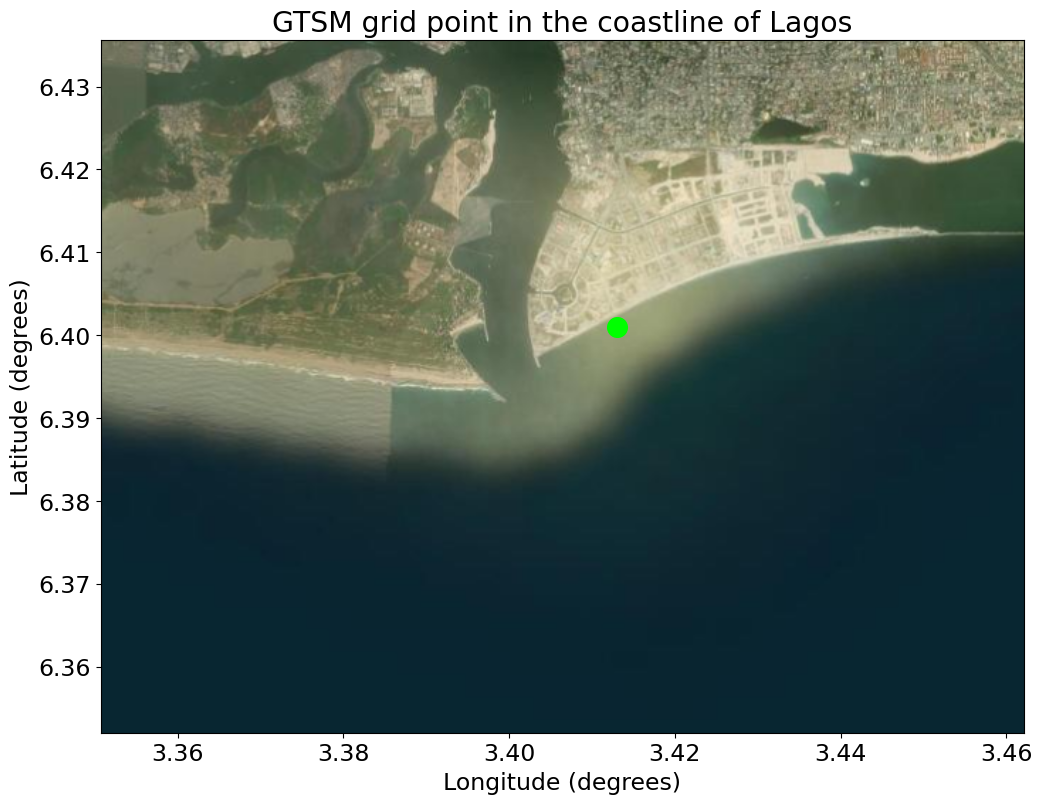

In [34]:
plt.rcParams['font.size'] = 17
fig, ax = plt.subplots(figsize=(15,9))
gdf_aoi.buffer(0.02).boundary.plot(ax=ax, color='blue', alpha=0)
plt.scatter(df_ts.station_x_coordinate[0], df_ts.station_y_coordinate[0], color='lime', zorder=2, s=200)
cx.add_basemap(ax=ax, crs=4326, source=cx.providers.Esri.WorldImagery, attribution=False)
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')
ax.set_title('GTSM grid point in the coastline of Lagos')

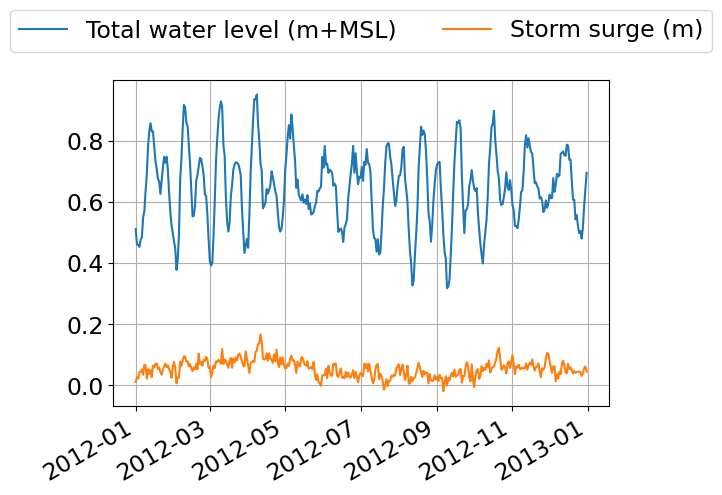

In [14]:


fig, ax = plt.subplots()

df_ts['waterlevel'].plot(ax=ax, label='Total water level (m+MSL)')
df_ts['surge'].plot(ax=ax, label='Storm surge (m)')
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend()
ax.grid()
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2)

In [ ]:
fn = os.path.join(glofas_dir, f'gtsm_sealevel_{years[0]}-{years[-1]}.nc')
concatenated_data = xr.open_dataset(fn)
longitudes = concatenated_data['station_x_coordinate']
latitudes = concatenated_data['station_y_coordinate']

# Create meshgrid for plotting
lon_mesh, lat_mesh = xr.broadcast(longitudes, latitudes)
df_grid = lon_mesh.to_dataframe().reset_index(drop=True)
df_grid = df_grid.loc[:, ~df_grid.columns.duplicated()]
df_grid['wl_max'] = 0
variable = concatenated_data['waterlevel']

# Set station_x_coordinate and station_y_coordinate as a MultiIndex
variable = variable.set_index(stations=['station_x_coordinate', 'station_y_coordinate'])

# Iterate over all lat/lon combinations

for index, row in df_grid.iterrows():

    # Extract the time series for the current lat/lon
    series = variable.sel(stations=(row['station_x_coordinate'], row['station_y_coordinate']))
    df_grid.loc[index, 'wl_max'] = series.values.max()

lon_sel = df_grid[df_grid['wl_max'] == df_grid['wl_max'].max()].longitude
lat_sel = df_grid[df_grid['wl_max'] == df_grid['wl_max'].max()].latitude

# Plot the grid
plt.rcParams['font.size'] = 17
fig, ax = plt.subplots(figsize=(15,9))
plt.plot(lon_mesh, lat_mesh, 'r.', markersize=20)
# gdf_aoi.boundary.plot(ax=ax, color='blue')
plt.scatter(lon_value, lat_value, color='lime', zorder=2, s=200)
cx.add_basemap(ax=ax, crs=4326, source=cx.providers.Esri.WorldTopoMap, attribution=False)
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')
ax.set_title('GLOFAS grid points in Kosofe and surroundings')

# Plot discharge time-series at maximum point

q_sel = concatenated_data['dis24'].sel(longitude=lon_sel.values, latitude=lat_sel.values)

fig, ax = plt.subplots(figsize=(10,7))
q_sel.plot(ax=ax, color='blue')
ax.set_xlabel('')
ax.set_ylabel('Discharge (cms)')
ax.grid()
ax.set_title(f'Average Daily Discharge at Ogun River at Kosofe (2022)')